## coin-average-backscatter

### Backscatter average using COIN processing results

This notebook does the backscatter average using COIN processing results

In [20]:
import os
import sys
sys.path.append(os.getcwd())
from coin_average_backscatter_helpers import *

import geopandas as gpd
import pandas as pd

%load_ext autoreload
%autoreload 2

import rasterio
import cioppy
import numpy
import control
import os
from os import path
from matplotlib import pyplot
from PIL import Image
from osgeo import gdal
import subprocess
from subprocess import Popen, PIPE
import shlex

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_path = os.getcwd()

average_dB = os.path.join(data_path, 'Sigma_average_dB.tif')

average_byte = os.path.join(data_path, 'Sigma_average_dB_byte.tif')

In [3]:
if not os.path.isdir(data_path):
    
    os.makedirs(data_path)

### Discover and stage-in the COIN results

In [4]:
result_endpoints = ['https://recast.terradue.com/t2api/describe/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/5ee13e8c-e380-11e9-8844-0242ac110028/0017887-190318164522056-oozie-oozi-W',                    
                    'https://recast.terradue.com/t2api/describe/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/ee8add00-e37f-11e9-8739-0242ac110028/0017874-190318164522056-oozie-oozi-W',
                    'https://recast.terradue.com/t2api/describe/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/1946f4ca-e380-11e9-b177-0242ac110028/0017881-190318164522056-oozie-oozi-W',
                    'https://recast.terradue.com/t2api/describe/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/53390e84-e380-11e9-bca4-0242ac110028/0017886-190318164522056-oozie-oozi-W',
                    'https://recast.terradue.com/t2api/describe/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/e88df108-e37f-11e9-a316-0242ac110028/0017868-190318164522056-oozie-oozi-W',
                    'https://recast.terradue.com/t2api/describe/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/103a8b8a-e380-11e9-a68d-0242ac110028/0017880-190318164522056-oozie-oozi-W',
                    'https://recast.terradue.com/t2api/describe/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/4cb9d6ec-e380-11e9-bd12-0242ac110028/0017885-190318164522056-oozie-oozi-W',
                    'https://recast.terradue.com/t2api/describe/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/dff5f72a-e37f-11e9-8156-0242ac110028/0017863-190318164522056-oozie-oozi-W',
                    'https://recast.terradue.com/t2api/describe/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/02bb0d72-e380-11e9-81be-0242ac110028/0017878-190318164522056-oozie-oozi-W',
                    'https://recast.terradue.com/t2api/describe/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/44df46b4-e380-11e9-b484-0242ac110028/0017884-190318164522056-oozie-oozi-W',
                    'https://recast.terradue.com/t2api/describe/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/fbed92f8-e37f-11e9-a320-0242ac110028/0017877-190318164522056-oozie-oozi-W',
                    'https://recast.terradue.com/t2api/describe/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/3df044b6-e380-11e9-b9c5-0242ac110028/0017883-190318164522056-oozie-oozi-W',
                    'https://recast.terradue.com/t2api/describe/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/f5254786-e37f-11e9-a49e-0242ac110028/0017876-190318164522056-oozie-oozi-W',
                    'https://recast.terradue.com/t2api/describe/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/3538820c-e380-11e9-ae6b-0242ac110028/0017882-190318164522056-oozie-oozi-W']
   
endpoints = pd.DataFrame(result_endpoints, columns=['endpoint'])

In [5]:
endpoints

endpoint
0   https://recast.terradue.com/t2api/describe/phi...
1   https://recast.terradue.com/t2api/describe/phi...
2   https://recast.terradue.com/t2api/describe/phi...
3   https://recast.terradue.com/t2api/describe/phi...
4   https://recast.terradue.com/t2api/describe/phi...
5   https://recast.terradue.com/t2api/describe/phi...
6   https://recast.terradue.com/t2api/describe/phi...
7   https://recast.terradue.com/t2api/describe/phi...
8   https://recast.terradue.com/t2api/describe/phi...
9   https://recast.terradue.com/t2api/describe/phi...
10  https://recast.terradue.com/t2api/describe/phi...
11  https://recast.terradue.com/t2api/describe/phi...
12  https://recast.terradue.com/t2api/describe/phi...
13  https://recast.terradue.com/t2api/describe/phi...

In [6]:
ciop = cioppy.Cioppy()

In [47]:
url_sigmadB = []

search_params = dict()

fields='identifier,enclosure,title'

for index, row in endpoints.iterrows():

    if index == 0:
        
        products = gpd.GeoDataFrame(ciop.search(end_point=row.endpoint,
                                            params=search_params,
                                            output_fields=fields,
                                            model='EOP'))
           
    else:
        
        results = gpd.GeoDataFrame(ciop.search(end_point=row.endpoint,
                                               params=search_params,
                                               output_fields=fields, 
                                               model='EOP'))

  
        if len(results) == 0:
        
            print ('Empty results')
           

    
        products = products.append(results)
        
   

In [33]:
products = products.reset_index(drop=True)  

In [48]:
products.sample(10)

startdate                       enddate  \
0            9999-12-31T23:59:59.9999999Z   
0            9999-12-31T23:59:59.9999999Z   
0            9999-12-31T23:59:59.9999999Z   
1            9999-12-31T23:59:59.9999999Z   
6            9999-12-31T23:59:59.9999999Z   
5            9999-12-31T23:59:59.9999999Z   
0            9999-12-31T23:59:59.9999999Z   
5            9999-12-31T23:59:59.9999999Z   
0            9999-12-31T23:59:59.9999999Z   
2            9999-12-31T23:59:59.9999999Z   

                                 identifier  \
0  92A3A81623CBD7AD654AF0431021A877DAD9C572   
0  91088F29AFAF2EE58ABACF1D4C2AA729A56B7956   
0  FCE5B8E279D361106635703051E20E9B81517231   
1  041E1514B125EBD5FF91A0FC8BE34C8F26DAB302   
6  E9C97A2965CE6DAC2261D830F16816781C10BC39   
5  9C2B99400AF9AF9F914C69DA41222A73FE3D975A   
0  D89A712B8DAF8D1F234436DE7C6E7D3568460B53   
5  C6CB29AE5E84D3C9516FA7C15A81954F29A669B9   
0  31CA9CB44F400B03BAC2128B50EC8D6BAFFB77A4   
2  455E92A32DC704BF536B34BA47D5332D84165424   

                                           enclosure  \
0  https://store.terradue.com/philippe.bally/_res...   
0  https://store.terradue.com/philippe.bally/_res...   
0  https://store.terradue.com/philippe.bally/_res...   
1  https://store.terradue.com/philippe.bally/_res...   
6  https://store.terradue.com/philippe.bally/_res...   
5  https://store.terradue.com/philippe.bally/_res...   
0  https://store.terradue.com/philippe.bally/_res...   
5  https://store.terradue.com/philippe.bally/_res...   
0  https://store.terradue.com/philippe.bally/_res...   
2  https://store.terradue.com/philippe.bally/_res...   

                                               title  
0   coh_sigmaAvrg_IW_VV_29Sep2019_05Sep2019_Coh_Ampl  
0   coh_sigmaAvrg_IW_VV_29Sep2019_24Aug2019_Coh_Ampl  
0   coh_sigmaAvrg_IW_VV_29Sep2019_12Aug2019_Coh_Ampl  
1                coherence_IW_VV_29Sep2019_11Sep2019  
6                      sigmaSlave_dB_IW_VV_17Sep2019  
5  sigmaSlave_dB_31Jul2019_sigmaMaster_dB_29Sep20...  
0   coh_sigmaAvrg_IW_VV_29Sep2019_18Aug2019_Coh_Ampl  
5  sigmaSlave_dB_30Aug2019_sigmaMaster_dB_29Sep20...  
0   coh_sigmaAvrg_IW_VV_29Sep2019_07Jul2019_Coh_Ampl  
2          sigmaAverage_dB_IW_VV_29Sep2019_31Jul2019

Select one of the master sigma0 results:

In [41]:
products[products.title.str.contains('sigmaMaster_dB_IW_VV')].iloc[0].enclosure

'https://store.terradue.com/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/5ee13e8c-e380-11e9-8844-0242ac110028/0017887-190318164522056-oozie-oozi-W/sigmaMaster_dB_IW_VV_29Sep2019.tif'

Create the list of the master sigma0 and all the slave sigma0

In [49]:
url_sigmadB = [products[products.title.str.contains('sigmaMaster_dB_IW_VV')].iloc[0].enclosure] + list(products[products.title.str.contains('sigmaSlave_dB_IW_VV')].enclosure.values)

In [50]:
url_sigmadB

['https://store.terradue.com/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/5ee13e8c-e380-11e9-8844-0242ac110028/0017887-190318164522056-oozie-oozi-W/sigmaMaster_dB_IW_VV_29Sep2019.tif',
 'https://store.terradue.com/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/5ee13e8c-e380-11e9-8844-0242ac110028/0017887-190318164522056-oozie-oozi-W/sigmaSlave_dB_IW_VV_01Jul2019.tif',
 'https://store.terradue.com/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/ee8add00-e37f-11e9-8739-0242ac110028/0017874-190318164522056-oozie-oozi-W/sigmaSlave_dB_IW_VV_05Sep2019.tif',
 'https://store.terradue.com/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/1946f4ca-e380-11e9-b177-0242ac110028/0017881-190318164522056-oozie-oozi-W/sigmaSlave_dB_IW_VV_06Aug2019.tif',
 'https://store.terradue.com/philippe.bally/_result

1
https://store.terradue.com/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/5ee13e8c-e380-11e9-8844-0242ac110028/0017887-190318164522056-oozie-oozi-W/sigmaMaster_dB_IW_VV_29Sep2019.tif


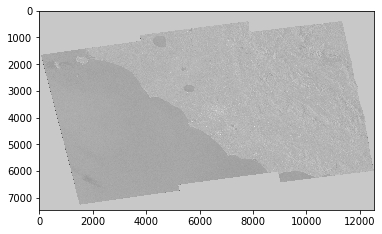

(7456, 12542)
2
https://store.terradue.com/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/5ee13e8c-e380-11e9-8844-0242ac110028/0017887-190318164522056-oozie-oozi-W/sigmaSlave_dB_IW_VV_01Jul2019.tif


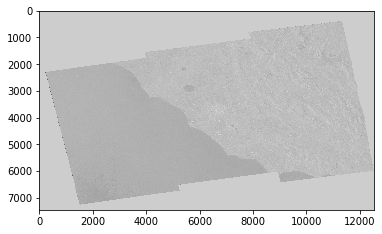

(7456, 12542)
3
https://store.terradue.com/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/ee8add00-e37f-11e9-8739-0242ac110028/0017874-190318164522056-oozie-oozi-W/sigmaSlave_dB_IW_VV_05Sep2019.tif


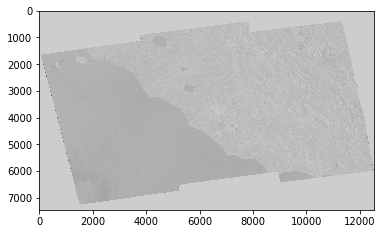

(7456, 12542)
4
https://store.terradue.com/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/1946f4ca-e380-11e9-b177-0242ac110028/0017881-190318164522056-oozie-oozi-W/sigmaSlave_dB_IW_VV_06Aug2019.tif


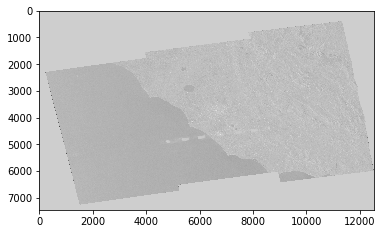

(7456, 12542)
5
https://store.terradue.com/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/53390e84-e380-11e9-bca4-0242ac110028/0017886-190318164522056-oozie-oozi-W/sigmaSlave_dB_IW_VV_07Jul2019.tif


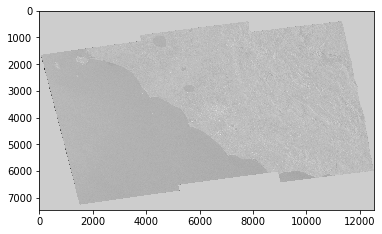

(7456, 12542)
6
https://store.terradue.com/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/e88df108-e37f-11e9-a316-0242ac110028/0017868-190318164522056-oozie-oozi-W/sigmaSlave_dB_IW_VV_11Sep2019.tif


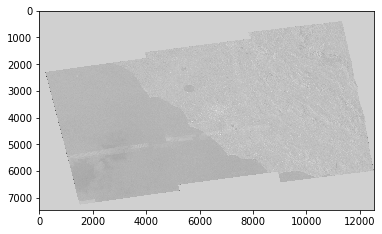

(7456, 12542)
7
https://store.terradue.com/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/103a8b8a-e380-11e9-a68d-0242ac110028/0017880-190318164522056-oozie-oozi-W/sigmaSlave_dB_IW_VV_12Aug2019.tif


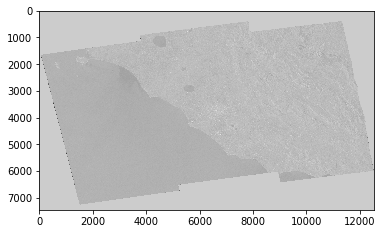

(7456, 12542)
8
https://store.terradue.com/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/4cb9d6ec-e380-11e9-bd12-0242ac110028/0017885-190318164522056-oozie-oozi-W/sigmaSlave_dB_IW_VV_13Jul2019.tif


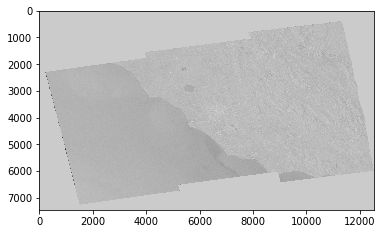

(7456, 12542)
9
https://store.terradue.com/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/dff5f72a-e37f-11e9-8156-0242ac110028/0017863-190318164522056-oozie-oozi-W/sigmaSlave_dB_IW_VV_17Sep2019.tif


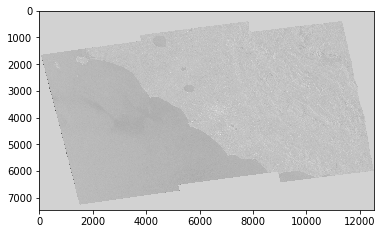

(7456, 12542)
10
https://store.terradue.com/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/02bb0d72-e380-11e9-81be-0242ac110028/0017878-190318164522056-oozie-oozi-W/sigmaSlave_dB_IW_VV_18Aug2019.tif


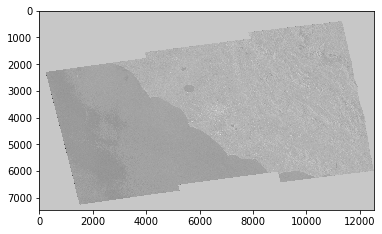

(7456, 12542)
11
https://store.terradue.com/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/44df46b4-e380-11e9-b484-0242ac110028/0017884-190318164522056-oozie-oozi-W/sigmaSlave_dB_IW_VV_19Jul2019.tif


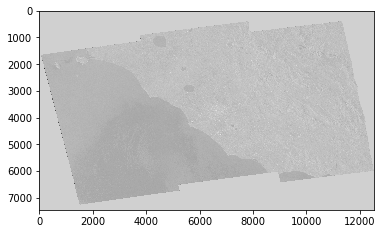

(7456, 12542)
12
https://store.terradue.com/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/fbed92f8-e37f-11e9-a320-0242ac110028/0017877-190318164522056-oozie-oozi-W/sigmaSlave_dB_IW_VV_24Aug2019.tif


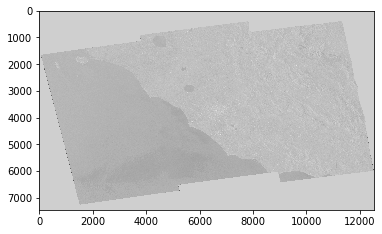

(7456, 12542)
13
https://store.terradue.com/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/3df044b6-e380-11e9-b9c5-0242ac110028/0017883-190318164522056-oozie-oozi-W/sigmaSlave_dB_IW_VV_25Jul2019.tif


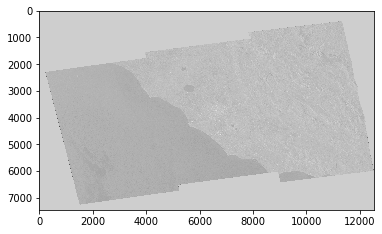

(7456, 12542)
14
https://store.terradue.com/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/f5254786-e37f-11e9-a49e-0242ac110028/0017876-190318164522056-oozie-oozi-W/sigmaSlave_dB_IW_VV_30Aug2019.tif


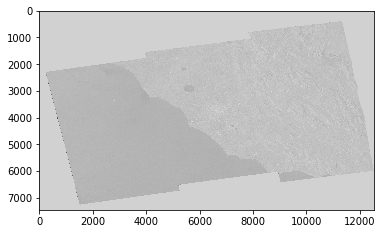

(7456, 12542)
15
https://store.terradue.com/philippe.bally/_results/workflows/geohazards_tep_dcs_rss_snap_s1_coin_snap_s1_coh_sigma_1_5_9/run/3538820c-e380-11e9-ae6b-0242ac110028/0017882-190318164522056-oozie-oozi-W/sigmaSlave_dB_IW_VV_31Jul2019.tif


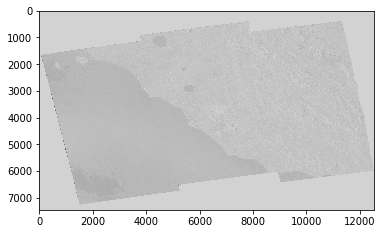

(7456, 12542)


In [67]:
sigma = []

for index, url in enumerate(url_sigmadB):
    
    print(str(index+1))
    print(url)
    
    with rasterio.open(url) as src:
        data = src.read(1)
        metadata = src.profile
        
    pyplot.imshow(data, cmap='gray')
    pyplot.show() 
    
    tens = numpy.full(data.shape,10)
    
    data_linear = numpy.power(tens, numpy.divide(data, 10))
    
    if index >= 1:
        sigma0 = numpy.add(sigma, data_linear)
    else:
        sigma0 = data_linear
    
    print(sigma0.shape)    
    sigma = sigma0

#### Read the results using rasterio and calculate the sigma mean with numpy

In [68]:
    
print(sigma.shape)

print('{} elements'.format(index))

(7456, 12542)
14 elements


Creating the mean Sigma [linear]

In [69]:
sigma_mean = numpy.divide(sigma, index)

Converting sigma mean linear to dB

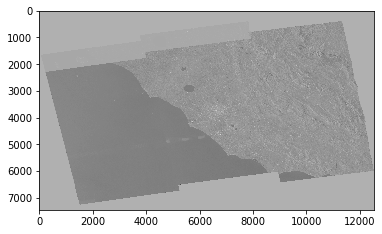

In [70]:
sigma_mean_dB = numpy.multiply(10, numpy.log10(sigma_mean))

pyplot.imshow(sigma_mean_dB, cmap='gray')

# writing result
with rasterio.open(average_dB, 'w', **metadata) as dst:
    dst.write(sigma_mean_dB.astype(rasterio.float32), 1)

Clip the average to [-15,5] db with gdal:

In [71]:
ds = gdal.Open(average_dB)

In [72]:
gdal.Translate(average_byte, 
               ds, 
               outputType=gdal.GDT_Byte, 
               scaleParams=[[-15,5,0,255]])

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f3acd1162a0> >

Show the result:

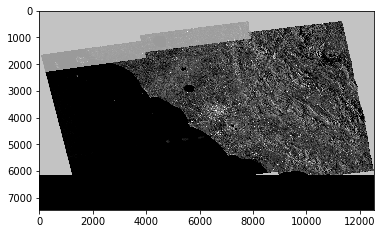

In [73]:
with rasterio.open(average_byte) as src:
    data = src.read(1)
    metadata = src.profile

pyplot.imshow(data, cmap='gray')
pyplot.show()  